In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import plotly as ply
import sklearn as skl
import datetime as dt 
import math
import random

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.linear_model import SGDRegressor

In [6]:
# load data 
df = pd.read_csv("books.csv")

# 1. data processing
- 'num_pages' spaces eliminated
- insert 'english' dummy feature, generated from 'language_code', represents by english or other languages

In [7]:
# num_pages space canceled
df = df.rename(columns= {"  num_pages": "num_pages"})

In [8]:
# English dummies
df['english'] = np.where(df['language_code'].str[0:2] == 'en', 1, 0)

In [9]:
cols_adjust = df.columns.tolist()
cols_adjust

['bookID',
 'title',
 'authors',
 'average_rating',
 'isbn',
 'isbn13',
 'language_code',
 'num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher',
 'english']

/var/folders/dz/3jfgccdn52ggwvy9spwly7y00000gn/T/ipykernel_23970/682619250.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['average_rating'],bins=20, color='red')


AttributeError: module 'matplotlib' has no attribute 'title'

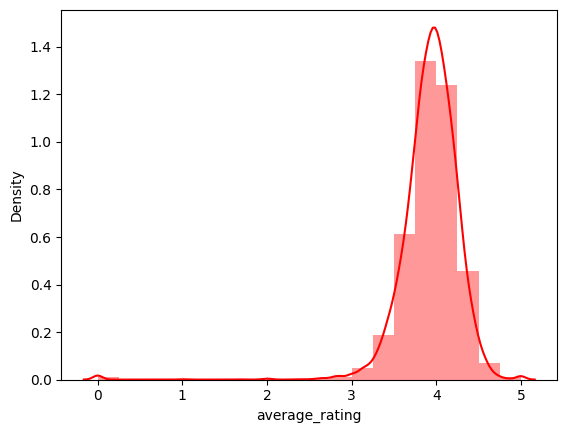

In [10]:
sns.distplot(df['average_rating'],bins=20, color='red')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.show()

# 2. round the value of 'average_rating' into quartile and decile 
### 2.1. generate two functions

In [11]:
# having discrete number of ratings 
def round_to_increment_25(number):
    '''Return the string version of the target rounded in .25% increments'''
    rounded_number = round(number / 0.25) * 0.25
    if 3.5 <= rounded_number and rounded_number <= 4.5:
        return str(rounded_number)
    else:
        if rounded_number > 4.5:
            return str(4.5)
        else:
            return str(1)
        
def round_to_increment_10(number):
    '''Return the string version of the target rounded in .1% increments'''
    rounded_number = round(number, 1)
    if 3.5 <= rounded_number and rounded_number <= 4.5:
        return str(rounded_number)
    else:
        if rounded_number > 4.5:
            return str(4.5)
        else:
            return str(1)

### 2.2. duplicate 2 dfs to adopt the changes

In [12]:
# original distribution of 'average_rating'
df['average_rating'].value_counts()

4.00    219
3.96    195
4.02    178
3.94    176
4.07    172
       ... 
4.91      1
3.10      1
3.03      1
2.99      1
2.33      1
Name: average_rating, Length: 209, dtype: int64

In [13]:
df_a = df.copy()
df_b = df.copy()

In [14]:
df_a['average_rating'] = df_a['average_rating'].apply(round_to_increment_25) # [1, 3.5, 3.75, 4, 4.25, 4.5]


In [15]:
df_b['average_rating'] = df_b['average_rating'].apply(round_to_increment_10) # [1, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5]

In [16]:
df_a['average_rating'].value_counts()

4.0     4000
3.75    2792
4.25    2336
3.5     1022
4.5      589
1        388
Name: average_rating, dtype: int64

In [17]:
df_b['average_rating'].value_counts()

4.0    1824
3.9    1573
3.8    1329
4.1    1318
4.2    1249
3.7     826
4.3     704
3.6     609
1       578
3.5     428
4.4     355
4.5     334
Name: average_rating, dtype: int64

# 3. model testing preparation
### 3.1. setting up R-squared and RMSE indices generating function

In [18]:
def model_cross_val(models={}, X_test=None, y_test=None, cv=None, scoring=()):
    scoring_method = ('r2', 'neg_root_mean_squared_error')

    table = {"r2": [], "neg_root_mean_squared_error": []}

    for mod in models:
        for sco in scoring_method:
            score = cross_val_score(models[mod], X_test, y_test, cv=cv, scoring=sco).mean()
            if sco == 'r2':
                table[sco].append(score)
            else:
                table[sco].append(abs(score))

    print(
        pd.DataFrame(data = table, index = models, columns=table.keys())
        .sort_values(by=list(table.keys())[0], ascending=False)
    )

### 3.2. setting up model selecting generator function

In [121]:
def model_selecting_generator(df=None):
    train0, test = train_test_split(df, test_size=20, random_state=42)

    # split train0 in train and valid
    train, valid = train_test_split(train0, test_size=40, random_state=42)

    # subsetting
    # train0
    X_train0 = train0.drop("average_rating", axis = 1)
    y_train0 = train0.average_rating

    # train
    X_train = train.drop("average_rating", axis = 1)
    y_train = train.average_rating

    # valid
    X_valid = valid.drop("average_rating", axis = 1)
    y_valid = valid.average_rating

    # test
    X_test = test.drop("average_rating", axis = 1)
    y_test = test.average_rating


    ## model selection process
    # Linear Regression
    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)

    # ridge model
    reg_ridge = linear_model.Ridge(alpha=0.01)
    reg_ridge.fit(X_train,y_train)

    # ridge CV
    reg_ridge_CV = linear_model.RidgeCV(alphas=[0.001,0.01,0.1,1,10],cv=5)
    reg_ridge_CV.fit(X_train0,y_train0)

    # lasso model
    reg_lasso = linear_model.Lasso(alpha=0.5)
    reg_lasso.fit(X_train,y_train)

    # random forest
    rfr = RandomForestRegressor(n_estimators = 100, random_state = 42)
    rfr.fit(X_train, y_train)

    # Support Vector Regression
    svr = SVR(C=1.0, epsilon=0.2)
    svr.fit(X_train, y_train)

    # Stochastic Gradient Descent Regressor
    sgdr = SGDRegressor(max_iter=1000, tol=1e-3)

    # Gradient BoostingRegressor
    gbm = GradientBoostingRegressor(random_state=42)


    # random forest classifier
    #rfc = RandomForestClassifier(max_depth=3, random_state=42)
    #rfc.fit(X)

    ## R2 + RMSE table
    models = {
        'linear reg': reg, 
        'ridge model': reg_ridge,
        'lasso model': reg_lasso,
        'ridge CV': reg_ridge_CV,
        'random forest': rfr,
        'support vector': svr,
        'SGDRegressor': sgdr,
        #'linearSVR': lsvr,
        'gradient b': gbm
    }

    return model_cross_val(models, X_test, y_test, cv=10)

### 3.3. setting data frame input automates

In [20]:
'''def many_df(df_list):
    for i in range(len(df_list)):
        print(df_list[i].columns.tolist())
        model_selecting_generator(df_list[i])
        print("--- \n")
'''

In [51]:
def many_df(df_list):
    for i in df_list:
        print(f"{i}: {df_list[i].columns.tolist()} \n")
        model_selecting_generator(df_list[i])
        print("--- \n")

### 3.4. index of data frames - part 2

In [99]:
# 4.1. feature engineering: none
df2_0 = df[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count']]

df2_1 = df[['average_rating', 'num_pages', 'text_reviews_count']]
df2_2 = df[['average_rating', 'num_pages', 'ratings_count']]
df2_3 = df[['average_rating', 'ratings_count', 'text_reviews_count']]

df2_4 = df[['average_rating', 'num_pages']]
df2_5 = df[['average_rating', 'text_reviews_count']]
df2_6 = df[['average_rating', 'ratings_count']]
#df2_x = [df2_0, df2_1, df2_2, df2_3, df2_4, df2_5, df2_6]
df2_x = {"df2_0": df2_0, "df2_1": df2_1, "df2_2":df2_2, "df2_3":df2_3, "df2_4":df2_4, "df2_5":df2_5, "df2_6":df2_6}


# 4.2. feature engineering: english dummies
df2_10 = df[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english']]

df2_11 = df[['average_rating', 'num_pages', 'text_reviews_count', 'english']]
df2_12 = df[['average_rating', 'ratings_count', 'num_pages', 'english']]
df2_13 = df[['average_rating', 'ratings_count', 'text_reviews_count', 'english']]

df2_14 = df[['average_rating', 'num_pages', 'english']]
df2_15 = df[['average_rating', 'text_reviews_count', 'english']]
df2_16 = df[['average_rating', 'ratings_count', 'english']]
#df2_1x = [df2_10, df2_11, df2_12, df2_13, df2_14, df2_15, df2_16]
df2_1x = {"df2_10":df2_10, "df2_11":df2_11, "df2_12":df2_12, "df2_13":df2_13, "df2_14":df2_14, "df2_15":df2_15, "df2_16":df2_16}


# 4.3. feature engineering: quartile 'average_rating'
df3_0 = df_a[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count']]

df3_1 = df_a[['average_rating', 'num_pages', 'text_reviews_count']]
df3_2 = df_a[['average_rating', 'num_pages', 'ratings_count']]
df3_3 = df_a[['average_rating', 'ratings_count', 'text_reviews_count']]

df3_4 = df_a[['average_rating', 'num_pages']]
df3_5 = df_a[['average_rating', 'text_reviews_count']]
df3_6 = df_a[['average_rating', 'ratings_count']]
#df3_x = [df3_0, df3_1, df3_2, df3_3, df3_4, df3_5, df3_6]
df3_x = {"df3_0":df3_0, "df3_1":df3_1, "df3_2":df3_2, "df3_3":df3_3, "df3_4":df3_4, "df3_5":df3_5, "df3_6":df3_6}


# 4.4. feature engineering: english dummies, quartile 'average_rating'
df3_10 = df_a[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english']]

df3_11 = df_a[['average_rating', 'num_pages', 'text_reviews_count', 'english']]
df3_12 = df_a[['average_rating', 'ratings_count', 'num_pages', 'english']]
df3_13 = df_a[['average_rating', 'ratings_count', 'text_reviews_count', 'english']]

df3_14 = df_a[['average_rating', 'num_pages', 'english']]
df3_15 = df_a[['average_rating', 'text_reviews_count', 'english']]
df3_16 = df_a[['average_rating', 'ratings_count', 'english']]
#df3_1x = [df3_10, df3_11, df3_12, df3_13, df3_14, df3_15, df3_16]
df3_1x = {"df3_10":df3_10, "df3_11":df3_11, "df3_12":df3_12, "df3_13":df3_13, "df3_14":df3_14, "df3_15":df3_15, "df3_16":df3_16}


# 4.5. feature engineering: decile 'average_rating'
df4_0 = df_b[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count']]

df4_1 = df_b[['average_rating', 'num_pages', 'text_reviews_count']]
df4_2 = df_b[['average_rating', 'num_pages', 'ratings_count']]
df4_3 = df_b[['average_rating', 'ratings_count', 'text_reviews_count']]

df4_4 = df_b[['average_rating', 'num_pages']]
df4_5 = df_b[['average_rating', 'text_reviews_count']]
df4_6 = df_b[['average_rating', 'ratings_count']]
#df4_x = [df4_0, df4_1, df4_2, df4_3, df4_4, df4_5, df4_6]
df4_x = {"df4_0":df4_0, "df4_1":df4_1, "df4_2":df4_2, "df4_3":df4_3, "df4_4":df4_4, "df4_5":df4_5, "df4_6":df4_6}


# 4.6. feature engineering: english dummies, decile 'average_rating'
df4_10 = df_b[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english']]

df4_11 = df_b[['average_rating', 'num_pages', 'text_reviews_count', 'english']]
df4_12 = df_b[['average_rating', 'ratings_count', 'num_pages', 'english']]
df4_13 = df_b[['average_rating', 'ratings_count', 'text_reviews_count', 'english']]

df4_14 = df_b[['average_rating', 'num_pages', 'english']]
df4_15 = df_b[['average_rating', 'text_reviews_count', 'english']]
df4_16 = df_b[['average_rating', 'ratings_count', 'english']]
#df4_1x = [df4_10, df4_11, df4_12, df4_13, df4_14, df4_15, df4_16]
df4_1x = {"df4_10":df4_10, "df4_11":df4_11, "df4_12":df4_12, "df4_13":df4_13, "df4_14":df4_14, "df4_15":df4_15, "df4_16":df4_16}



# 4. model testing - numeric variables

### 4.1. feature engineering: none
df2_0 - df2_6

In [122]:
many_df(df2_x)

df2_0: ['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count'] 

                          r2  neg_root_mean_squared_error
lasso model    -1.368071e+00                 1.695997e-01
support vector -1.448790e+00                 1.784014e-01
ridge CV       -2.063746e+00                 1.814740e-01
ridge model    -2.066523e+00                 1.815173e-01
linear reg     -2.066526e+00                 1.815174e-01
gradient b     -2.960260e+00                 1.805301e-01
random forest  -4.580882e+00                 1.841039e-01
SGDRegressor   -1.530296e+37                 8.377784e+16
--- 

df2_1: ['average_rating', 'num_pages', 'text_reviews_count'] 

                          r2  neg_root_mean_squared_error
random forest  -1.610271e+00                 1.668059e-01
support vector -2.301561e+00                 1.891379e-01
lasso model    -2.502406e+00                 1.801207e-01
ridge CV       -2.591104e+00                 1.813462e-01
ridge model    -2.591114e+00           

### 4.2. feature engineering: english dummies
df2_10 - df2_16

In [123]:
many_df(df2_1x)

df2_10: ['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english'] 

                          r2  neg_root_mean_squared_error
lasso model    -1.368071e+00                 1.695997e-01
support vector -1.442117e+00                 1.783968e-01
gradient b     -2.421711e+00                 1.766635e-01
ridge model    -3.422697e+00                 1.784875e-01
linear reg     -3.434876e+00                 1.785184e-01
ridge CV       -3.482528e+00                 1.793402e-01
random forest  -4.609585e+00                 1.800898e-01
SGDRegressor   -5.008880e+37                 6.133390e+16
--- 

df2_11: ['average_rating', 'num_pages', 'text_reviews_count', 'english'] 

                          r2  neg_root_mean_squared_error
support vector -2.257741e+00                 1.888020e-01
random forest  -2.259819e+00                 1.722258e-01
lasso model    -2.502406e+00                 1.801207e-01
ridge CV       -2.888840e+00                 1.755939e-01
gradient b     

### 4.3. feature engineering: quartile 'average_rating'
df3_0 - df3_6

In [124]:
many_df(df3_x)

df3_0: ['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count'] 

                          r2  neg_root_mean_squared_error
lasso model     8.364807e-04                 1.819325e-01
random forest  -4.573778e-02                 1.805654e-01
ridge CV       -5.268561e-02                 1.940288e-01
ridge model    -5.297264e-02                 1.940738e-01
linear reg     -5.297293e-02                 1.940739e-01
gradient b     -9.357883e-02                 1.844203e-01
support vector -2.981423e-01                 1.890094e-01
SGDRegressor   -1.684460e+35                 7.601923e+16
--- 

df3_1: ['average_rating', 'num_pages', 'text_reviews_count'] 

                          r2  neg_root_mean_squared_error
random forest   9.627722e-02                 1.734976e-01
lasso model    -1.449951e-03                 1.752102e-01
ridge CV       -4.228350e-03                 1.759073e-01
ridge model    -4.230062e-03                 1.759075e-01
linear reg     -4.230062e-03           

### 4.4. feature engineering: english dummies, quartile 'average_rating'
df3_10 - df3_16

In [125]:
many_df(df3_1x)

df3_10: ['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english'] 

                          r2  neg_root_mean_squared_error
lasso model     8.364807e-04                 1.819325e-01
random forest  -6.502778e-03                 1.787029e-01
gradient b     -1.257123e-01                 1.839947e-01
ridge model    -2.509949e-01                 1.841413e-01
linear reg     -2.545171e-01                 1.841553e-01
ridge CV       -2.894274e-01                 2.005368e-01
support vector -2.986847e-01                 1.890551e-01
SGDRegressor   -1.641320e+34                 1.968894e+16
--- 

df3_11: ['average_rating', 'num_pages', 'text_reviews_count', 'english'] 

                          r2  neg_root_mean_squared_error
random forest   1.137311e-01                 1.696126e-01
lasso model    -1.449951e-03                 1.752102e-01
ridge CV       -1.335956e-01                 1.708715e-01
ridge model    -1.862172e-01                 1.727131e-01
support vector 

### 4.5. feature engineering: decile 'average_rating'
df4_0 - df4_6

In [126]:
many_df(df4_x)

df4_0: ['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count'] 

                          r2  neg_root_mean_squared_error
lasso model    -7.090926e-01                 1.727187e-01
support vector -8.587433e-01                 1.805538e-01
ridge CV       -9.090063e-01                 1.835152e-01
ridge model    -9.100095e-01                 1.835605e-01
linear reg     -9.100105e-01                 1.835606e-01
gradient b     -1.161759e+00                 1.849439e-01
random forest  -2.260407e+00                 1.917911e-01
SGDRegressor   -1.518858e+37                 4.201214e+16
--- 

df4_1: ['average_rating', 'num_pages', 'text_reviews_count'] 

                          r2  neg_root_mean_squared_error
random forest  -6.645608e-01                 1.669132e-01
gradient b     -1.193185e+00                 1.642203e-01
lasso model    -1.251133e+00                 1.860161e-01
ridge CV       -1.287192e+00                 1.872567e-01
ridge model    -1.287198e+00           

### 4.6. feature engineering: english dummies, decile 'average_rating'
df4_10 - df4_16

In [127]:
many_df(df4_1x)

df4_10: ['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english'] 

                          r2  neg_root_mean_squared_error
lasso model    -7.090926e-01                 1.727187e-01
support vector -8.557520e-01                 1.805583e-01
gradient b     -1.227470e+00                 1.855232e-01
ridge CV       -1.828784e+00                 1.840503e-01
ridge model    -1.971790e+00                 1.856299e-01
linear reg     -1.980606e+00                 1.856833e-01
random forest  -2.109921e+00                 1.854364e-01
SGDRegressor   -6.890447e+35                 8.411802e+16
--- 

df4_11: ['average_rating', 'num_pages', 'text_reviews_count', 'english'] 

                          r2  neg_root_mean_squared_error
random forest  -8.987417e-01                 1.695685e-01
lasso model    -1.251133e+00                 1.860161e-01
support vector -1.409687e+00                 1.952221e-01
ridge CV       -1.429753e+00                 1.829450e-01
gradient b     

# 5. hyperparameter
in the above result table we could see that adopting df3_11 (['average_rating', 'num_pages', 'text_reviews_count', 'english']) in Random Forest model owns the best model performance with the r2 value being 0.11 and RMSE value 0.169.

df3_11: ['average_rating', 'num_pages', 'text_reviews_count', 'english'] 

                     r2  neg_root_mean_squared_error
random forest  0.113731                     0.169613
lasso model   -0.001450                     0.175210
ridge CV      -0.133596                     0.170872
ridge model   -0.186217                     0.172713
linear reg    -0.189962                     0.172763

df3_4: ['average_rating', 'num_pages'] 

                     r2  neg_root_mean_squared_error
lasso model    0.029643                     0.169054
ridge model    0.029183                     0.168953
linear reg     0.029183                     0.168953
ridge CV       0.029182                     0.168953
random forest -0.471054                     0.195285

### 5.1 setting up random parameters grid - random forest

In [84]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num = 15)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [128]:
# Create the random grid
random_grid_1 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [92]:
# random grid for 2 parameters
random_grid_2 = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

### 5.2 setting up hyperparameter tuning function - random forest

In [87]:
def hyper_tune_rf(df=None, rand_grid=None):
    train0, test = train_test_split(df, test_size=20, random_state=42)

    # split train0 in train and valid
    train, valid = train_test_split(train0, test_size=40, random_state=42)

    # subsetting
    # train0
    X_train0 = train0.drop("average_rating", axis = 1)
    y_train0 = train0.average_rating

    # train
    X_train = train.drop("average_rating", axis = 1)
    y_train = train.average_rating

    # valid
    X_valid = valid.drop("average_rating", axis = 1)
    y_valid = valid.average_rating

    # test
    X_test = test.drop("average_rating", axis = 1)
    y_test = test.average_rating


    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rand_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
        
    return rf_random.best_params_

### 5.3 adopting at the best df: df_11

In [129]:
hyper_tune_rf(df3_11, random_grid_1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this paramete

[CV] END bootstrap=False, max_depth=130, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.8s
[CV] END bootstrap=False, max_depth=130, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.8s
[CV] END bootstrap=False, max_depth=130, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   5.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   5.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   5.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   9.5s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.4s
[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   9.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this paramete

[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   9.7s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.3s
[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.7s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=140, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  14.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=140, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  14.1s
[CV] END bootstrap=False, max_depth=140, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  14.7s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   4.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.9s
[CV] END bootstrap=True, max_depth=140, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=140, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=140, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  12.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  12.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  13.3s
[CV] END bootstrap=False, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   4.6s
[CV] END bootstrap=False, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   4.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=140, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   5.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=140, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=140, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   6.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.8s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.7s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   6.4s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=   6.4s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   6.4s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   6.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   3.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   3.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   3.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   6.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   6.7s
[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   6.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time=   6.6s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   3.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   3.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   3.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  16.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  16.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  17.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=  12.6s
[CV] END bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=  12.6s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=  13.0s
[CV] END bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this paramete

[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.3s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=  15.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=  15.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=  14.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   9.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   9.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   8.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=140, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=130, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=  12.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=130, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=  13.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this paramete

[CV] END bootstrap=False, max_depth=130, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=  12.5s
[CV] END bootstrap=True, max_depth=140, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=140, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   6.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   6.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   6.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  14.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  14.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  14.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=140, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=140, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END bootstrap=True, max_depth=140, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=False, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700; total time=   6.7s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   5.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   4.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   5.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   4.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   4.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   4.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   6.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   6.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  10.6s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  10.9s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700; total time=  11.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   5.8s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  13.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  14.2s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=  13.8s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   5.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   6.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   6.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.5s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.7s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   6.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   6.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time=   8.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   7.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=  10.6s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=  10.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   8.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   8.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   8.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.8s
[CV] END bootstrap=False, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.4s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=  10.5s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.9s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  12.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  12.1s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  12.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.5s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.7s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.7s
[CV] END bootstrap=False, max_depth=140, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  16.7s
[CV] END bootstrap=False, max_depth=150, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=150, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.7s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=150, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.9s
[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.8s
[CV] END bootstrap=False, max_depth=140, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  17.4s
[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=140, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  16.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.8s
[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  14.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  15.1s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time=  14.4s
[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.9s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.6s
[CV] END bootstrap=False, max_depth=1

/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=140, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   3.7s
[CV] END bootstrap=False, max_depth=140, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   3.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=140, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   3.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   4.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   4.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   4.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   9.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   9.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   3.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   8.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   3.7s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   6.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   3.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   3.7s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   8.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.4s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   8.5s
[CV] END bootstrap=True, max_depth=130, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   8.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   7.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   7.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   6.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   6.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   6.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.2s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.9s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   3.3s
[CV] END bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=7

/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  14.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  14.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.0s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   5.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  14.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   5.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   6.1s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   4.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   4.5s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   4.6s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  11.8s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  11.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  12.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=  10.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=  10.4s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.3s


/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  13.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  13.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=  13.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700; total time=   8.8s
[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   7.8s
[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   7.6s
[CV] END bootstrap=True, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   7.5s


{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

In [93]:
hyper_tune_rf(df3_11, random_grid_2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ....bootstrap=False, max_depth=80, n_estimators=100; total time=   1.9s
[CV] END ....bootstrap=False, max_depth=80, n_estimators=100; total time=   2.2s
[CV] END ....bootstrap=False, max_depth=80, n_estimators=100; total time=   2.2s
[CV] END .....bootstrap=True, max_depth=70, n_estimators=400; total time=   5.3s
[CV] END .....bootstrap=True, max_depth=30, n_estimators=600; total time=   7.8s
[CV] END .....bootstrap=True, max_depth=70, n_estimators=400; total time=   5.5s
[CV] END .....bootstrap=True, max_depth=30, n_estimators=600; total time=   7.8s
[CV] END ....bootstrap=False, max_depth=10, n_estimators=800; total time=   8.2s
[CV] END ....bootstrap=False, max_depth=10, n_estimators=800; total time=   8.3s
[CV] END ....bootstrap=False, max_depth=10, n_estimators=800; total time=   8.4s
[CV] END ....bootstrap=True, max_depth=120, n_estimators=100; total time=   1.1s
[CV] END ....bootstrap=True, max_depth=120, n_

/Users/m22/conda/envs/env_pylab/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ....bootstrap=False, max_depth=30, n_estimators=700; total time=  12.2s
[CV] END ....bootstrap=False, max_depth=30, n_estimators=700; total time=  12.4s
[CV] END ....bootstrap=False, max_depth=90, n_estimators=500; total time=   8.8s
[CV] END ....bootstrap=False, max_depth=90, n_estimators=500; total time=   8.5s
[CV] END ....bootstrap=False, max_depth=90, n_estimators=500; total time=   9.3s
[CV] END ....bootstrap=True, max_depth=100, n_estimators=100; total time=   1.2s
[CV] END ....bootstrap=True, max_depth=100, n_estimators=100; total time=   1.3s
[CV] END ....bootstrap=True, max_depth=100, n_estimators=100; total time=   1.3s
[CV] END ....bootstrap=False, max_depth=70, n_estimators=500; total time=   9.0s
[CV] END .....bootstrap=True, max_depth=90, n_estimators=300; total time=   4.2s
[CV] END .....bootstrap=True, max_depth=90, n_estimators=300; total time=   4.4s
[CV] END ....bootstrap=False, max_depth=70, n_estimators=500; total time=  10.4s
[CV] END .....bootstrap=True

{'n_estimators': 1000, 'max_depth': 10, 'bootstrap': True}

In [70]:
train0, test = train_test_split(df3_11, test_size=20, random_state=42)

# split train0 in train and valid
train, valid = train_test_split(train0, test_size=40, random_state=42)

# subsetting
# train0
X_train0 = train0.drop("average_rating", axis = 1)
y_train0 = train0.average_rating

# train
X_train = train.drop("average_rating", axis = 1)
y_train = train.average_rating

# valid
X_valid = valid.drop("average_rating", axis = 1)
y_valid = valid.average_rating

# test
X_test = test.drop("average_rating", axis = 1)
y_test = test.average_rating

### 5.4 generating R2 and RMSE by using the best parameter outcome back to the rf model

In [71]:
rf = RandomForestRegressor(n_estimators= 3000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'sqrt', max_depth= 10, bootstrap= True)

In [75]:
rf = RandomForestRegressor(n_estimators= 400, min_samples_split= 2, min_samples_leaf= 4, max_features= 'sqrt', max_depth= 10, bootstrap= True)

In [89]:
rf = RandomForestRegressor(n_estimators= 800, min_samples_split= 10, min_samples_leaf= 4, max_features= 'sqrt', max_depth= 10, bootstrap= True)

In [94]:
rf = RandomForestRegressor(n_estimators= 1000, max_depth= 10, bootstrap= True)

In [81]:
# the origin parameter setting
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [95]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=1000)

In [96]:
scoring_method = ('r2', 'neg_root_mean_squared_error')

table = {"r2": [], "neg_root_mean_squared_error": []}


for sco in scoring_method:
    score = cross_val_score(rf, X_test, y_test, cv=10, scoring=sco).mean()
    if sco == 'r2':
        table[sco].append(score)
    else:
        table[sco].append(abs(score))

print(
    pd.DataFrame(data = table, columns=table.keys())
    .sort_values(by=list(table.keys())[0], ascending=False)
)

         r2  neg_root_mean_squared_error
0  0.105363                     0.165971


# the outcome is not promising by using hyperparameter tuning
            r2      neg_root_mean_squared_error
100   0.113731                       0.166174
3000 -0.068277                       0.177725
400  -0.07045                        0.178091
800  -0.087129                       0.178527

1000  0.105363                       0.165971

In [130]:
def remove_outliers(X,bins = 50, plot = "bool"):
    # q1 and q3 quantiles
    q1,q3 = X.quantile([0.25,0.75])

    #interquatile range 
    iqr = q3 - q1
   

    # remove  q1 - 1.5*iqr or  q3 + 1.5*iqr:
    X =  X[X.between(q1 - 1.5*iqr, q3 + 1.5*iqr,inclusive = "both")]
       

    # histogram
    if plot :
          X.hist( bins = bins,legend = {""})
    return X